# Лабораторна робота №7
Мета: Розробка та порівняння моделей глибокого навчання для мультикласової класифікації трьох класів зображень їжі, а також використання transfer learning для покращення результатів.



Попередня Обробка: Завантажте та розпакуйте набір даних.
Поділіть дані на тренувальний, валідаційний та тестовий набори.
Виконайте необхідну попередню обробку даних.
Розробка та Тренування Моделей:

Створіть три різні моделі глибокого навчання для класифікації обраних класів. Наприклад, ви можете змінювати архітектуру, кількість шарів, активаційні функції тощо.
Тренуйте кожну модель на тренувальному наборі даних та валідуйте їх на валідаційному наборі.
Оцінка Моделей:

Оцініть кожну модель на тестовому наборі даних.
Запишіть та порівняйте результати точності та часу тренування для кожної моделі.
Додаткове Завдання (на високу оцінку):

Використайте transfer learning з використанням EfficientNet з TensorFlow Hub для класифікації тих самих трьох класів.
Порівняйте результати цієї моделі з попередніми трьома за точністю та часом тренування.

## 1. Вивчення даних

### 1.1 Підключення бібліотек

In [76]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

### 1.2 Вивід даних, підрахунок к-сті даних

In [77]:
!dir 3_food_classes\train\

 Volume in drive D has no label.
 Volume Serial Number is 227C-445D

 Directory of d:\Lessons\3rd Year, 1st course\Intelligent data analysis\My main local repo (for labs, practicies)\ml2023\Labs\Lab7\3_food_classes\train

28.11.2023  18:37    <DIR>          .
28.11.2023  18:37    <DIR>          ..
28.11.2023  18:33    <DIR>          chicken_curry
28.11.2023  18:35    <DIR>          chicken_wings
28.11.2023  18:38    <DIR>          ice_cream
               0 File(s)              0 bytes
               5 Dir(s)  10�969�706�496 bytes free


In [78]:
import os

# Walk through 3_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk("3_food_classes"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '3_food_classes'.
There are 3 directories and 0 images in '3_food_classes\test'.
There are 0 directories and 150 images in '3_food_classes\test\chicken_curry'.
There are 0 directories and 150 images in '3_food_classes\test\chicken_wings'.
There are 0 directories and 150 images in '3_food_classes\test\ice_cream'.
There are 3 directories and 0 images in '3_food_classes\train'.
There are 0 directories and 700 images in '3_food_classes\train\chicken_curry'.
There are 0 directories and 700 images in '3_food_classes\train\chicken_wings'.
There are 0 directories and 700 images in '3_food_classes\train\ice_cream'.
There are 3 directories and 0 images in '3_food_classes\val'.
There are 0 directories and 150 images in '3_food_classes\val\chicken_curry'.
There are 0 directories and 150 images in '3_food_classes\val\chicken_wings'.
There are 0 directories and 150 images in '3_food_classes\val\ice_cream'.


In [79]:
# Another way to find out how many images are in a file
num_curry_images_train = len(os.listdir("3_food_classes/train/chicken_curry"))
num_curry_images_train

700

In [80]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
data_dir = pathlib.Path("3_food_classes/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['chicken_curry' 'chicken_wings' 'ice_cream']


### 1.3 Вивід фото і робота з ним

In [81]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)


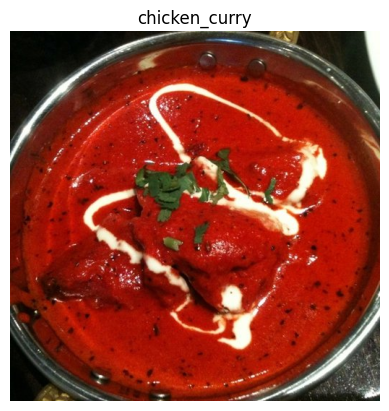

In [82]:
# View a random image from the training dataset
img = view_random_image(target_dir="3_food_classes/train/",
                        target_class="chicken_curry")

In [83]:
# View the img (actually just a big array/tensor)
img

array([[[  3,  10,   3],
        [  2,   9,   2],
        [  1,   8,   1],
        ...,
        [254, 255, 247],
        [253, 255, 247],
        [253, 255, 247]],

       [[  3,  10,   3],
        [  2,   9,   2],
        [  1,   8,   1],
        ...,
        [254, 255, 247],
        [253, 255, 247],
        [253, 255, 247]],

       [[  3,  10,   3],
        [  2,   9,   2],
        [  1,   8,   1],
        ...,
        [254, 255, 247],
        [253, 255, 247],
        [253, 255, 247]],

       ...,

       [[  2,   7,   3],
        [  2,   7,   3],
        [  2,   7,   3],
        ...,
        [ 17,  30,  21],
        [ 22,  35,  26],
        [ 22,  38,  28]],

       [[  1,   6,   2],
        [  1,   6,   2],
        [  1,   6,   2],
        ...,
        [  9,  24,  17],
        [ 15,  32,  24],
        [ 20,  37,  29]],

       [[  0,   4,   0],
        [  0,   5,   1],
        [  1,   6,   2],
        ...,
        [ 17,  34,  26],
        [ 22,  39,  31],
        [ 16,  36,  27]]

In [84]:
# View the image shape
img.shape # returns (width, height, colour channels)

(512, 512, 3)

In [85]:
# Get all the pixel values between 0 & 1
img/255. 

array([[[0.01176471, 0.03921569, 0.01176471],
        [0.00784314, 0.03529412, 0.00784314],
        [0.00392157, 0.03137255, 0.00392157],
        ...,
        [0.99607843, 1.        , 0.96862745],
        [0.99215686, 1.        , 0.96862745],
        [0.99215686, 1.        , 0.96862745]],

       [[0.01176471, 0.03921569, 0.01176471],
        [0.00784314, 0.03529412, 0.00784314],
        [0.00392157, 0.03137255, 0.00392157],
        ...,
        [0.99607843, 1.        , 0.96862745],
        [0.99215686, 1.        , 0.96862745],
        [0.99215686, 1.        , 0.96862745]],

       [[0.01176471, 0.03921569, 0.01176471],
        [0.00784314, 0.03529412, 0.00784314],
        [0.00392157, 0.03137255, 0.00392157],
        ...,
        [0.99607843, 1.        , 0.96862745],
        [0.99215686, 1.        , 0.96862745],
        [0.99215686, 1.        , 0.96862745]],

       ...,

       [[0.00784314, 0.02745098, 0.01176471],
        [0.00784314, 0.02745098, 0.01176471],
        [0.00784314, 0

## 2. Підготовка даних

In [86]:
train_dir = "./3_food_classes/train"
valid_dir = "./3_food_classes/val"
test_dir = "./3_food_classes/test"

In [87]:
class_names = os.listdir(train_dir)
class_names

['chicken_curry', 'chicken_wings', 'ice_cream']

 ### 2.1 Обробка та аугментація даних. Переформатування зображень. 

ImageDataGenerator є класом з бібліотеки TensorFlow, призначеним для автоматичної генерації попередньо оброблених зображень для тренування нейронних мереж. Він надає можливість виконувати попередню обробку та аугментацію даних безпосередньо під час тренування.

height_shift_range: максимальний діапазон зсуву висоти (вертикального зсуву) для зображень під час аугментації. 0.2 = 20%

width_shift_range: максимальний діапазон горизонтального зсуву для зображень.

rotation_range: максимальний діапазон випадкового повороту зображень у градусах. 0.15 = 15 градусів

horizontal_flip: вказує, чи слід випадковим чином виконувати горизонтальне відображення (перевертання) зображень.

shear_range: максимальний діапазон зсуву (зміщення) у градусах для зображень. Використовується для зміщення пікселів в напрямку, перпендикулярному осі вісі зображення.

zoom_range: Вказує максимальний діапазон випадкового збільшення або зменшення зображень. Наприклад, zoom_range=0.25 дозволяє збільшувати або зменшувати зображення на до 25%.

In [88]:
# Set the seed
tf.random.set_seed(42)

In [89]:
# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size: Це кількість зображень, які будуть завантажені за одну ітерацію. У цьому випадку кожен пакет міститиме 32 зображення.

seed: Це параметр для задання початкового значення для генератора випадкових чисел.

target_size: Це розмір, до якого будуть ресайзити всі зображення під час завантаження

A common practice is to reshape images all to one size. In our case, we'll resize the images to (224, 224, 3), meaning a height and width of 224 pixels and a depth of 3 for the red, green, blue colour channels.

In [90]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42
)

valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42
)

Found 2100 images belonging to 3 classes.
Found 450 images belonging to 3 classes.
Found 450 images belonging to 3 classes.


### 2.2 Вивід зображень

Image shape: (384, 512, 3)
Image shape: (512, 512, 3)
Image shape: (512, 512, 3)
Image shape: (512, 382, 3)


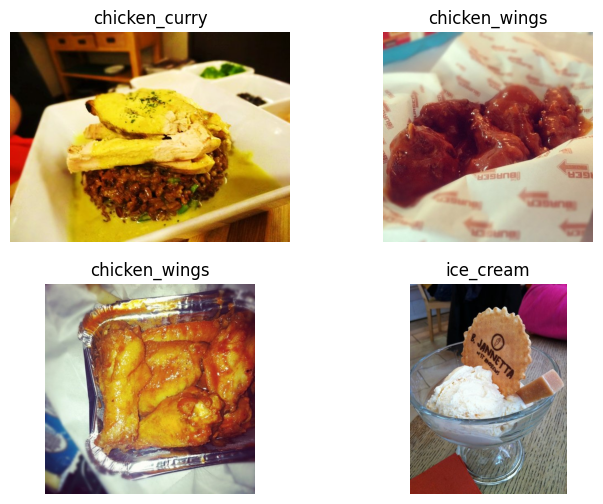

In [91]:
plt.figure(figsize=(8, 6))

for i in range(0, 4):
    class_name = random.choice(os.listdir(train_dir))
    random_path = random.choice(os.listdir(train_dir + '/' + class_name))
    img_path = train_dir + '/' + class_name + '/' + random_path
    ax = plt.subplot(2, 2, i+1)
    img = mpimg.imread(img_path)
    print(f"Image shape: {img.shape}") # show the shape of the image
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

### 2.3 Вивід після відформатування

In [92]:
# Get a sample of the training data batch 
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [93]:
# Get the first two images
images[:2], images[0].shape

(array([[[[0.77647066, 0.72156864, 0.7176471 ],
          [0.7490196 , 0.69411767, 0.6901961 ],
          [0.75294125, 0.69803923, 0.69411767],
          ...,
          [0.05882353, 0.04313726, 0.03137255],
          [0.05882353, 0.04313726, 0.03137255],
          [0.05882353, 0.04313726, 0.03137255]],
 
         [[0.7411765 , 0.69803923, 0.6901961 ],
          [0.7411765 , 0.69803923, 0.6901961 ],
          [0.7372549 , 0.69411767, 0.6862745 ],
          ...,
          [0.05882353, 0.04313726, 0.03137255],
          [0.05490196, 0.03921569, 0.02745098],
          [0.0627451 , 0.04705883, 0.03529412]],
 
         [[0.73333335, 0.69411767, 0.6862745 ],
          [0.7294118 , 0.6901961 , 0.68235296],
          [0.7294118 , 0.6901961 , 0.68235296],
          ...,
          [0.0627451 , 0.04705883, 0.03529412],
          [0.05882353, 0.04313726, 0.03137255],
          [0.0627451 , 0.04705883, 0.03529412]],
 
         ...,
 
         [[0.3921569 , 0.3137255 , 0.21568629],
          [0.48235

In [94]:
# View the first batch of labels
labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

## 3. Побудова першої моделі 

In [95]:
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_1 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


# Fit the model
start_time_1 = time.time()
history_1 = model_1.fit(train_data, # use same training data created above
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data, # use same validation data created above
                        validation_steps=len(valid_data))
training_time_1 = time.time() - start_time_1

# Оцінка моделі на тестовому наборі
test_loss_1, test_accuracy_1 = model_1.evaluate(test_data)

# Вивід результатів
print('\n')
print(f'Test Accuracy: {test_accuracy_1}')
print(f'Test Loss: {test_loss_1}')
print(f'Training Time: {training_time_1} seconds')

Epoch 1/5
66/66 [==============================] - 13s 182ms/step - loss: 1.5041 - accuracy: 0.3229 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 2/5
66/66 [==============================] - 14s 216ms/step - loss: 1.0987 - accuracy: 0.3186 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 3/5
66/66 [==============================] - 11s 160ms/step - loss: 1.0987 - accuracy: 0.3143 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 4/5
66/66 [==============================] - 10s 144ms/step - loss: 1.0987 - accuracy: 0.3290 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 5/5
15/15 [==============================] - 2s 116ms/step - loss: 1.0986 - accuracy: 0.3333


Test Accuracy: 0.3333333432674408
Test Loss: 1.0986292362213135
Training Time: 57.92707586288452 seconds


<Axes: >

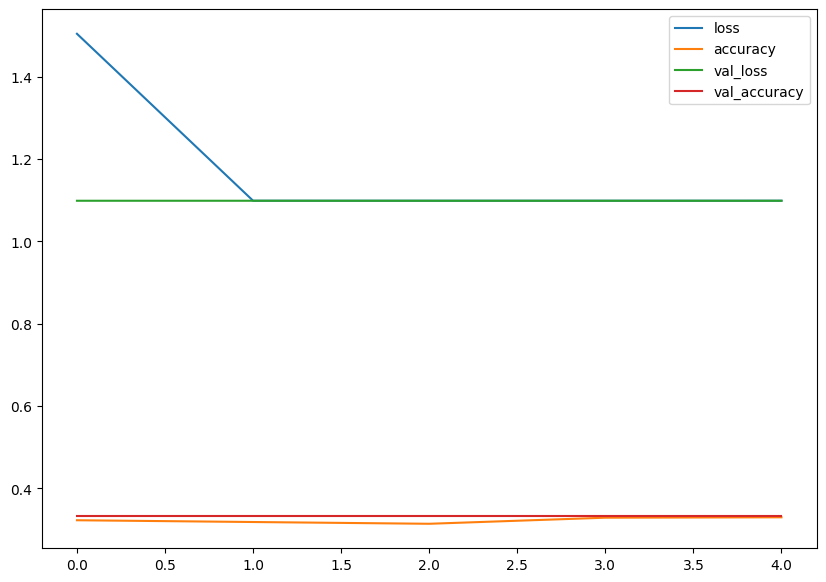

In [96]:
pd.DataFrame(history_1.history).plot(figsize=(10, 7))

In [97]:
# Check out the layers in our model
model_1.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 150528)            0         
                                                                 
 dense_33 (Dense)            (None, 4)                 602116    
                                                                 
 dense_34 (Dense)            (None, 4)                 20        
                                                                 
 dense_35 (Dense)            (None, 3)                 15        
                                                                 
Total params: 602151 (2.30 MB)
Trainable params: 602151 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 4. Побудова другої моделі

The "2D" means our inputs are two dimensional (height and width), even though they have 3 colour channels, the convolutions are run on each channel invididually.

filters - these are the number of "feature extractors" that will be moving over our images.

kernel_size - the size of our filters, for example, a kernel_size of (3, 3) (or just 3) will mean each filter will have the size 3x3, meaning it will look at a space of 3x3 pixels each time. The smaller the kernel, the more fine-grained features it will extract.

stride - the number of pixels a filter will move across as it covers the image. A stride of 1 means the filter moves across each pixel 1 by 1. A stride of 2 means it moves 2 pixels at a time.

padding - this can be either 'same' or 'valid', 'same' adds zeros the to outside of the image so the resulting output of the convolutional layer is the same as the input, where as 'valid' (default) cuts off excess pixels where the filter doesn't fit (e.g. 224 pixels wide divided by a kernel size of 3 (224/3 = 74.6) means a single pixel will get cut off the end.

In [99]:
# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(3, activation="softmax") # binary activation output
])

# Compile the model
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
start_time_2 = time.time()
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))
training_time_2 = time.time() - start_time_2

# Оцінка моделі на тестовому наборі
test_loss_2, test_accuracy_2 = model_2.evaluate(test_data)

# Вивід результатів
print('\n')
print(f'Test Accuracy: {test_accuracy_2}')
print(f'Test Loss: {test_loss_2}')
print(f'Training Time: {training_time_2} seconds')

Epoch 1/5
66/66 [==============================] - 92s 1s/step - loss: 0.9004 - accuracy: 0.5586 - val_loss: 0.8298 - val_accuracy: 0.5911
Epoch 2/5
66/66 [==============================] - 90s 1s/step - loss: 0.7713 - accuracy: 0.6490 - val_loss: 0.7623 - val_accuracy: 0.6556
Epoch 3/5
66/66 [==============================] - 90s 1s/step - loss: 0.7145 - accuracy: 0.6867 - val_loss: 0.7846 - val_accuracy: 0.6467
Epoch 4/5
66/66 [==============================] - 90s 1s/step - loss: 0.6565 - accuracy: 0.7071 - val_loss: 0.7504 - val_accuracy: 0.6800
Epoch 5/5
15/15 [==============================] - 6s 380ms/step - loss: 0.7675 - accuracy: 0.6756


Test Accuracy: 0.6755555272102356
Test Loss: 0.7674830555915833
Training Time: 456.3677611351013 seconds


<Axes: >

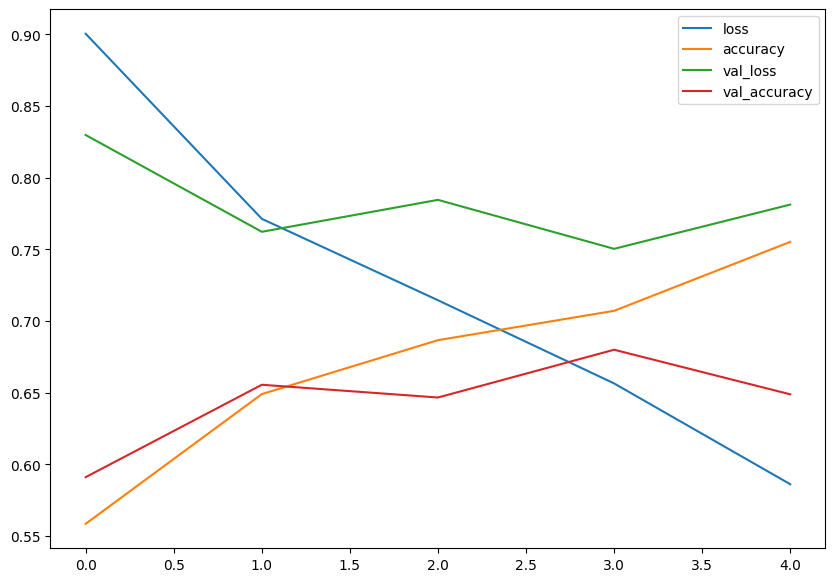

In [100]:
pd.DataFrame(history_2.history).plot(figsize=(10, 7))

In [101]:
# Check out the layers in our model
model_2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_17 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 110, 110, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_19 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                

## 5. Побудова третьої моделі

In [102]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

A simple convolutional neural network architecture ready to go.

And it follows the typical CNN structure of: Input -> Conv + ReLU layers (non-linearities) -> Pooling layer -> Fully connected (dense layer) as Output

In [103]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_3 = Sequential([
  Conv2D(filters=10, 
         kernel_size=3, 
         strides=1,
         padding='valid',
         activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(3, activation='softmax') # output layer (specify output shape)
])

# Compile the model
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
start_time_3 = time.time()
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))
training_time_3 = time.time() - start_time_3

# Оцінка моделі на тестовому наборі
test_loss_3, test_accuracy_3 = model_3.evaluate(test_data)

# Вивід результатів
print('\n')
print(f'Test Accuracy: {test_accuracy_3}')
print(f'Test Loss: {test_loss_3}')
print(f'Training Time: {training_time_3} seconds')

Epoch 1/5
66/66 [==============================] - 129s 2s/step - loss: 1.7155 - accuracy: 0.5057 - val_loss: 0.9614 - val_accuracy: 0.4978
Epoch 2/5
66/66 [==============================] - 119s 2s/step - loss: 0.8389 - accuracy: 0.6033 - val_loss: 0.8760 - val_accuracy: 0.5978
Epoch 3/5
66/66 [==============================] - 113s 2s/step - loss: 0.6993 - accuracy: 0.6938 - val_loss: 0.9029 - val_accuracy: 0.5867
Epoch 4/5
66/66 [==============================] - 123s 2s/step - loss: 0.4268 - accuracy: 0.8514 - val_loss: 0.8702 - val_accuracy: 0.6000
Epoch 5/5
15/15 [==============================] - 7s 475ms/step - loss: 1.0151 - accuracy: 0.5956


Test Accuracy: 0.5955555438995361
Test Loss: 1.0150785446166992
Training Time: 601.628502368927 seconds


In [104]:
# Check lengths of training and test data generators
len(train_data), len(valid_data)

(66, 15)

<Axes: >

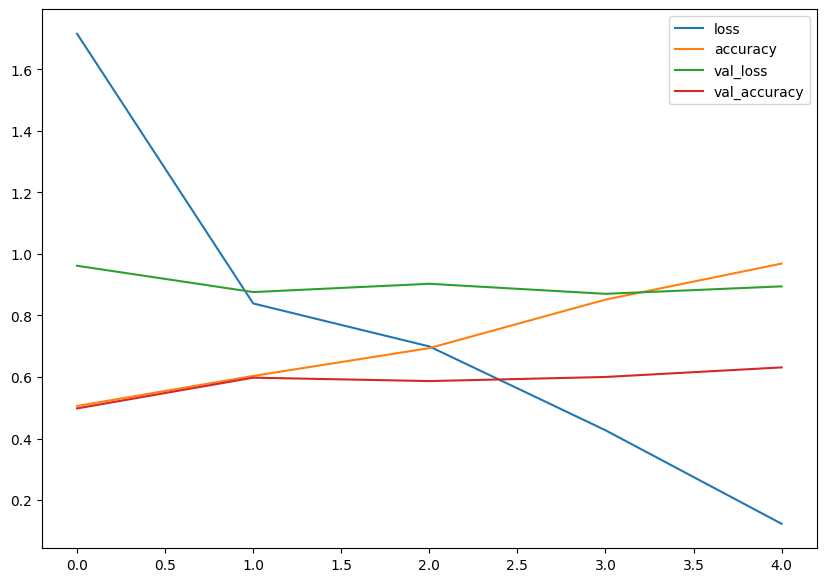

In [105]:
# Plot the training curves
import pandas as pd
pd.DataFrame(history_3.history).plot(figsize=(10, 7))

In [106]:
model_3.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_21 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 conv2d_22 (Conv2D)          (None, 218, 218, 10)      910       
                                                                 
 flatten_16 (Flatten)        (None, 475240)            0         
                                                                 
 dense_38 (Dense)            (None, 3)                 1425723   
                                                                 
Total params: 1427823 (5.45 MB)
Trainable params: 1427823 (5.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


And there are even a few more things we could try to further overfit our model:

Increase the number of convolutional layers.
Increase the number of convolutional filters.
Add another dense layer to the output of our flattened layer.

But what we'll do instead is focus on getting our model's training curves to better align with eachother, in other words, we'll take on step 2.

Why is reducing overfitting important?

When a model performs too well on training data and poorly on unseen data, it's not much use to us if we wanted to use it in the real world.

## 6. Transfer Learning (Взяття готової моделі) 

In [113]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_4 = Sequential()

pre_model = tf.keras.applications.Xception(
    include_top=False,
    input_shape=(224, 224, 3),
    classes=3,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classifier_activation="softmax",
)

for layer in pre_model.layers:
    layer.trainable=False

model_4.add(pre_model)
model_4.add(Flatten())
model_4.add(Dense(10, activation='relu'))
model_4.add(Dense(3, activation='softmax'))

# Compile the model
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
start_time_4 = time.time()
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))
training_time_4 = time.time() - start_time_4

# Оцінка моделі на тестовому наборі
test_loss_4, test_accuracy_4 = model_4.evaluate(test_data)

# Вивід результатів
print('\n')
print(f'Test Accuracy: {test_accuracy_4}')
print(f'Test Loss: {test_loss_4}')
print(f'Training Time: {training_time_4} seconds')

Epoch 1/5
66/66 [==============================] - 328s 5s/step - loss: 0.9936 - accuracy: 0.8357 - val_loss: 0.4086 - val_accuracy: 0.9311
Epoch 2/5
66/66 [==============================] - 309s 5s/step - loss: 0.2970 - accuracy: 0.9386 - val_loss: 0.5220 - val_accuracy: 0.9067
Epoch 3/5
66/66 [==============================] - 344s 5s/step - loss: 0.1072 - accuracy: 0.9686 - val_loss: 0.5744 - val_accuracy: 0.9200
Epoch 4/5
66/66 [==============================] - 306s 5s/step - loss: 0.0538 - accuracy: 0.9790 - val_loss: 0.4357 - val_accuracy: 0.9200
Epoch 5/5
15/15 [==============================] - 63s 4s/step - loss: 0.4765 - accuracy: 0.9222


Test Accuracy: 0.9222221970558167
Test Loss: 0.4765078127384186
Training Time: 1639.8586838245392 seconds


In [114]:
model_4.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_19 (Flatten)        (None, 100352)            0         
                                                                 
 dense_41 (Dense)            (None, 10)                1003530   
                                                                 
 dense_42 (Dense)            (None, 3)                 33        
                                                                 
Total params: 21865043 (83.41 MB)
Trainable params: 1003563 (3.83 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


<Axes: >

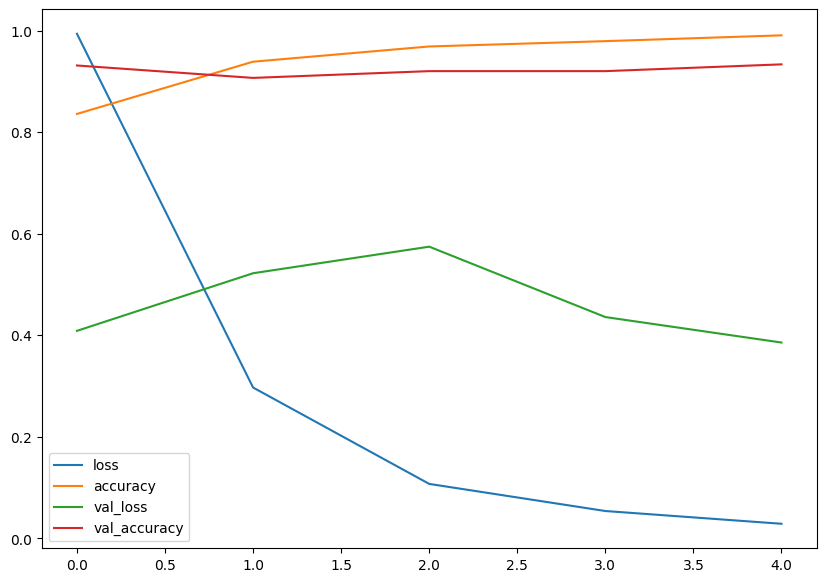

In [115]:
pd.DataFrame(history_4.history).plot(figsize=(10, 7))

## 6. Висновки, порівняння

In [116]:
model_results = [["model_1", test_loss_1, test_accuracy_1, training_time_1],
                 ["model_2", test_loss_2, test_accuracy_2, training_time_2],
                 ["model_3", test_loss_3, test_accuracy_3, training_time_3],
                 ["model_4", test_loss_4, test_accuracy_4, training_time_4]]

all_results = pd.DataFrame(model_results, columns=["model", "test_loss", "test_accuracy", "training_time"])
all_results

,model,test_loss,test_accuracy,training_time
0,model_1,1.098629,0.333333,57.927076
1,model_2,0.767483,0.675556,456.367761
2,model_3,1.015079,0.595556,601.628502
3,model_4,0.476508,0.922222,1639.858684
